<h3>Imports<h3>

In [22]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

**<h4>Inputs<h4>**

---



In [24]:
def load_local_data(folder_path, symbol, start_year=2019, end_year=2024):
    """
    Load and combine CSV files from a local folder using the format DAT_ASCII_EURUSD_M1_2019.csv.
    Handles files with no header and semicolon-separated values.
    """
    import os
    import pandas as pd

    all_data = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(
            folder_path, f"DAT_ASCII_{symbol.upper()}_M1_{year}.csv"
        )
        if os.path.exists(file_path):
            print(f"Loading data from {file_path}")
            df = pd.read_csv(
                file_path,
                sep=";",
                header=None,
                names=["datetime", "open", "high", "low", "close", "volume"],
                engine="python"
            )
            # Parse datetime
            df['timestamp'] = pd.to_datetime(df['datetime'], format='%Y%m%d %H%M%S')
            all_data.append(df)
        else:
            print(f"Warning: File not found - {file_path}")

    if not all_data:
        raise ValueError("No data files were found!")

    combined_data = pd.concat(all_data, ignore_index=True)
    combined_data = combined_data.sort_values('timestamp')
    return combined_data

In [27]:
def resample_data(data, timeframe):
    """
    Resample data to a different timeframe.
    
    Parameters:
    data (pd.DataFrame): Input dataframe with OHLC data
    timeframe (str): Target timeframe (e.g., '5min', '15min', '1h', '4h', '1d')
    
    Returns:
    pd.DataFrame: Resampled dataframe
    """
    # Make a copy to avoid modifying the original
    df = data.copy()
    
    # Set timestamp as index for resampling
    df = df.set_index('timestamp')
    
    # Map common timeframe strings to pandas resample rule
    timeframe_map = {
        '1min': '1min',
        '5min': '5min', 
        '15min': '15min',
        '30min': '30min',
        '1h': '1h',
        '4h': '4h',
        '1d': 'D'
    }
    
    # Get the appropriate resample rule
    resample_rule = timeframe_map.get(timeframe, timeframe)
    
    # Resample the data
    resampled = df.resample(resample_rule).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum' if 'volume' in df.columns else None
    }).dropna()
    
    # Reset index to get timestamp as a column again
    resampled = resampled.reset_index()
    
    return resampled

<h3>Asset<h3>

In [28]:
# Define parameters
name_base = "EURUSD"  # Already defined in your notebook
name_quote = ""  # Not needed for FX data
timeframe = "1h"  # Change this to your desired timeframe: 1min, 5min, 15min, 1h, 4h, 1d, etc.

# Path to your data folder
data_folder = r"D:\KGDFRY\Forex Trading\GitHub\FX-1-Minute-Data\eurusd"

# Date ranges for backtesting
starting_date_backtest = "2019-01-01"
ending_date_backtest = "2023-12-31"

# Load the data from CSV files
raw_data = load_local_data(data_folder, name_base.lower(), start_year=2019, end_year=2024)

# If the timeframe is not 1min, resample the data
if timeframe != "1min":
    print(f"Resampling data to {timeframe} timeframe")
    data = resample_data(raw_data, timeframe)
else:
    data = raw_data

# Filter data for the backtest period
data = data[(data['timestamp'] >= pd.to_datetime(starting_date_backtest)) & 
            (data['timestamp'] <= pd.to_datetime(ending_date_backtest))]

print(f"Loaded {len(data)} {timeframe} candles from {data['timestamp'].min()} to {data['timestamp'].max()}")

# Display the first few rows
data.head()

Loading data from D:\KGDFRY\Forex Trading\GitHub\FX-1-Minute-Data\eurusd\DAT_ASCII_EURUSD_M1_2019.csv
Loading data from D:\KGDFRY\Forex Trading\GitHub\FX-1-Minute-Data\eurusd\DAT_ASCII_EURUSD_M1_2020.csv
Loading data from D:\KGDFRY\Forex Trading\GitHub\FX-1-Minute-Data\eurusd\DAT_ASCII_EURUSD_M1_2021.csv
Loading data from D:\KGDFRY\Forex Trading\GitHub\FX-1-Minute-Data\eurusd\DAT_ASCII_EURUSD_M1_2022.csv
Loading data from D:\KGDFRY\Forex Trading\GitHub\FX-1-Minute-Data\eurusd\DAT_ASCII_EURUSD_M1_2023.csv
Loading data from D:\KGDFRY\Forex Trading\GitHub\FX-1-Minute-Data\eurusd\DAT_ASCII_EURUSD_M1_2024.csv
Resampling data to 1h timeframe
Loaded 30310 1h candles from 2019-01-01 17:00:00 to 2023-12-29 16:00:00


,timestamp,open,high,low,close,volume
0,2019-01-01 17:00:00,1.14598,1.14672,1.14598,1.14606,0
1,2019-01-01 18:00:00,1.14605,1.14676,1.14566,1.14612,0
2,2019-01-01 19:00:00,1.14612,1.14626,1.14543,1.14561,0
3,2019-01-01 20:00:00,1.14561,1.14563,1.14457,1.14521,0
4,2019-01-01 21:00:00,1.14521,1.14533,1.14426,1.14456,0


<h3>Data<h3>

In [29]:
timeframe = "15m"
starting_date_backtest = "01 january 2020"
ending_date_backtest =  "31 december 2024"
starting_date_dl = "01 january 2019"
ending_date_dl = "31 december 2024"

<h3>Portfolio<h3>

In [ ]:
initial_capital = 100000 # in quote
exposure = 2           # position size in percent
# exposure = 'all'       # use this instead if you want 100% of your portfolio to be used for each trade
trade_fees = 0.01       # in percent
leverage = 2000

<h4>Strategy flags<h4>

In [31]:
ignore_shorts = False
ignore_longs = False

ignore_tp = False
ignore_sl = False
ignore_exit = False

**<h5>Strategy<h5>**

---

In [32]:
def compute_indicators(data): # check https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html
    data['EMAf'] = ta.trend.ema_indicator(data['close'], 10)
    data['EMAs'] = ta.trend.ema_indicator(data['close'], 30)
    data['Trend'] = ta.trend.sma_indicator(data['close'], 50)
    data['RSI'] = ta.momentum.rsi(data['close'])
    data['ATR'] = ta.volatility.average_true_range(data['high'], data['low'], data['close'], window=14)

    # MACD = ta.trend.MACD(data['close'], window_slow=26, window_fast=12, window_sign=9)
    # data['MACD'] = MACD.macd()
    # data['MACD_histo'] = MACD.macd_diff()
    # data['MACD_signal'] = MACD.macd_signal()

    # BB = ta.volatility.BollingerBands(close=data['close'], window=100, window_dev=2)
    # data["BB_lower"] = BB.bollinger_lband()
    # data["BB_upper"] = BB.bollinger_hband()
    # data["BB_avg"] = BB.bollinger_mavg()

    return data

In [33]:
def prepare_data(data, starting_date, ending_date):
    """
    Prepare data for backtesting by computing indicators and filtering by date.
    
    Parameters:
    data (pd.DataFrame): Input dataframe with OHLC data
    starting_date (str): Start date for backtesting (YYYY-MM-DD)
    ending_date (str): End date for backtesting (YYYY-MM-DD)
    
    Returns:
    pd.DataFrame: Prepared dataframe with indicators
    """
    data2 = data.copy()
    data2 = compute_indicators(data2)  # Assuming this function exists in your notebook
    
    # Filter by date range
    data2 = data2[(data2['timestamp'] >= pd.to_datetime(starting_date)) & 
                  (data2['timestamp'] <= pd.to_datetime(ending_date))]
    
    data2.dropna(inplace=True)
    return data2

In [34]:
data = prepare_data(data, starting_date_backtest, ending_date_backtest)
data

,timestamp,open,high,low,close,volume,EMAf,EMAs,Trend,RSI,ATR
6213,2020-01-01 17:00:00,1.12120,1.12166,1.12106,1.12143,0,1.121790,1.121166,1.120558,50.856952,0.000907
6214,2020-01-01 18:00:00,1.12143,1.12218,1.12142,1.12188,0,1.121806,1.121212,1.120653,53.949483,0.000896
6215,2020-01-01 19:00:00,1.12188,1.12190,1.12157,1.12183,0,1.121810,1.121252,1.120732,53.546280,0.000856
6216,2020-01-01 20:00:00,1.12182,1.12244,1.12180,1.12209,0,1.121861,1.121306,1.120811,55.412395,0.000840
6217,2020-01-01 21:00:00,1.12210,1.12245,1.12184,1.12222,0,1.121926,1.121365,1.120880,56.356440,0.000824
...,...,...,...,...,...,...,...,...,...,...,...
30305,2023-12-29 12:00:00,1.10607,1.10667,1.10529,1.10639,0,1.106070,1.106917,1.108696,48.323129,0.001643
30306,2023-12-29 13:00:00,1.10640,1.10640,1.10491,1.10530,0,1.105930,1.106812,1.108577,44.576017,0.001632
30307,2023-12-29 14:00:00,1.10532,1.10538,1.10381,1.10407,0,1.105592,1.106636,1.108448,40.737210,0.001628
30308,2023-12-29 15:00:00,1.10409,1.10507,1.10383,1.10409,0,1.105319,1.106471,1.108314,40.826445,0.001600


<h3>Longs<h3>

In [35]:
def check_long_entry_condition(row, previous_row):
    return row['close'] > row['Trend'] and row['EMAf'] > row['EMAs'] and previous_row['EMAf'] < previous_row['EMAs'] and row['RSI'] < 70


def check_long_exit_condition(row, previous_row):
    return row['EMAf'] < row['EMAs'] and previous_row['EMAf'] > previous_row['EMAs']


def compute_long_sl_level(row, entry_price):
    return entry_price - 2 * row['ATR']


def compute_long_tp_level(row, entry_price, stop_loss_price):
    risk_reward_ratio = 4
    return entry_price * (1 + risk_reward_ratio * (1 - stop_loss_price / entry_price))
    # return row['open'] * 1.1

<h3>Shorts<h3>

In [36]:
def check_short_entry_condition(row, previous_row):
    return row['close'] < row['Trend'] and row['EMAf'] < row['EMAs'] and previous_row['EMAf'] > previous_row['EMAs'] and row['RSI'] > 30


def check_short_exit_condition(row, previous_row):
    return row['EMAf'] > row['EMAs'] and previous_row['EMAf'] < previous_row['EMAs']


def compute_short_sl_level(row, entry_price):
    return entry_price + 2 * row['ATR']


def compute_short_tp_level(row, entry_price, stop_loss_price):
    risk_reward_ratio = 4
    return entry_price * (1 - risk_reward_ratio * (stop_loss_price / entry_price - 1))

**<h5>Core Functions<h5>**

---

In [37]:
def calculate_position_size(balance, exposure, entry_price, stop_loss_price):
    if exposure == 'all':
        return balance
    risked_amount = balance * (exposure / 100)
    position = risked_amount * entry_price / abs(entry_price - stop_loss_price)
    return min(balance, position)


def calculate_liquidation_price(price, leverage, order_type):
        if order_type == 'long':
            return price * (1 - 1 / leverage)
        elif order_type == 'short':
            return price * (1 + 1 / leverage)


def calculate_pnl(entry_price, exit_price, quantity, order_type):
    if order_type == 'long':
        return (exit_price - entry_price) * quantity
    elif order_type == 'short':
        return (entry_price - exit_price) * quantity

In [ ]:
def record_order(timestamp, type, price, amount, pnl, wallet, fee, orders):
    order = {
        'timestamp': timestamp,
        'type': type,
        'price' : price,
        'amount': amount,
        'fee': fee,
        'pnl': pnl,
        'wallet': wallet,
    }
    orders.append(order)
    print(f"{type} at {price} {name_quote} on {timestamp}, amount = {round(amount,2)} {name_quote}, pnl = {round(pnl,2)} {name_quote}, wallet = {round(wallet,2)} {name_quote}")

In [44]:
def run_backtest(data):

    # Initialize variables
    orders = []
    order_in_progress = None
    last_ath = 0
    sl_price = 0
    tp_price = 0
    long_liquidation_price = 0
    short_liquidation_price = 1e10
    wallet = initial_capital
    data['realised_pnl'] = ''
    data['unrealised_pnl'] = ''
    data['hodl'] = ''
    data['drawdown'] = ''
    previous_row = data.iloc[0]


    # Go through data and make trades
    for index, row in data.iterrows():
        price = row['close']


        # check if it is time to close a long
        if order_in_progress == 'long' and not ignore_longs:
            
            if row['low'] < long_liquidation_price:
                print(f' /!\\ Your long was liquidated on the {row["timestamp"]} (price = {long_liquidation_price} {name_quote})')
                pnl = calculate_pnl(entry_price, long_liquidation_price, quantity, order_in_progress)
                fee_exit = quantity * long_liquidation_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long liquidation', long_liquidation_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_sl and row['low'] <= sl_price:
                pnl = calculate_pnl(entry_price, sl_price, quantity, order_in_progress)
                fee_exit = quantity * sl_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long sl', sl_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_tp and row['high'] >= tp_price:
                pnl = calculate_pnl(entry_price, tp_price, quantity, order_in_progress)
                fee_exit = quantity * tp_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long tp', tp_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_exit and check_long_exit_condition(row, previous_row):
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long exit', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            if wallet > last_ath:
                last_ath = wallet


        # check if it is time to close a short
        elif order_in_progress == 'short' and not ignore_shorts:
            if row['high'] > short_liquidation_price:
                print(f' /!\\ Your short was liquidated on the {row["timestamp"]} (price = {short_liquidation_price} {name_quote})')
                pnl = calculate_pnl(entry_price, short_liquidation_price, quantity, order_in_progress)
                fee_exit = quantity * short_liquidation_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short liquidation', short_liquidation_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_sl and row['high'] >= sl_price:
                pnl = calculate_pnl(entry_price, sl_price, quantity, order_in_progress)
                fee_exit = quantity * sl_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short sl', sl_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_tp and row['low'] <= tp_price:
                pnl = calculate_pnl(entry_price, tp_price, quantity, order_in_progress)
                fee_exit = quantity * tp_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short tp', tp_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_exit and check_short_exit_condition(row, previous_row):
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short exit', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            if wallet > last_ath:
                last_ath = wallet


        # check it is time to enter a long
        if not ignore_longs and order_in_progress == None:
            if check_long_entry_condition(row, previous_row):
                order_in_progress = 'long'
                if not ignore_sl:
                    sl_price = compute_long_sl_level(row, price)
                if not ignore_tp:
                    tp_price = compute_long_tp_level(row, price, sl_price)
                entry_price = price
                position = calculate_position_size(wallet, exposure, price, sl_price)
                amount = position * leverage
                fee_entry = amount * trade_fees / 100
                quantity = (amount - fee_entry) / price
                long_liquidation_price = calculate_liquidation_price(price, leverage, order_in_progress)
                if wallet > last_ath:
                    last_ath = wallet

                wallet -= position
                record_order(row['timestamp'], 'long entry', price, amount-fee_entry, -fee_entry, wallet, fee_entry, orders)


        # check if it is time to enter a short
        if not ignore_shorts and order_in_progress == None:
            if check_short_entry_condition(row, previous_row):
                order_in_progress = 'short'
                if not ignore_sl:
                    sl_price = compute_short_sl_level(row, price)
                if not ignore_tp:
                    tp_price = compute_short_tp_level(row, price, sl_price)
                entry_price = price
                position = calculate_position_size(wallet, exposure, price, sl_price)
                amount = position * leverage
                fee_entry = amount * trade_fees / 100
                quantity = (amount - fee_entry) / price
                short_liquidation_price = calculate_liquidation_price(price, leverage, order_in_progress)
                wallet -= position
                record_order(row['timestamp'], 'short entry', price, amount-fee_entry, -fee_entry, wallet, fee_entry, orders)


        # updating wallet info
        data.at[index, 'realised_pnl'] = wallet
        data.at[index, 'unrealised_pnl'] = data.at[index, 'realised_pnl']
        if order_in_progress != None:
            data.at[index, 'unrealised_pnl'] += position + calculate_pnl(entry_price, price, quantity, order_in_progress) #- fee
        data.at[index, 'hodl'] = initial_capital / data["close"].iloc[0] * price
        data.at[index, 'drawdown'] = (data.at[index, 'unrealised_pnl'] - last_ath) / last_ath if last_ath else 0

        previous_row = row

    return data, orders

**<h1>Backtest<h1>**

---

<h3>Run<h3>

In [45]:
data, backtest_orders = run_backtest(data)

long entry at 1.11785  on 2020-01-06 03:00:00, amount = 19998000.0 , pnl = -2000.0 , wallet = 0 
 /!\ Your long was liquidated on the 2020-01-07 02:00:00 (price = 1.117291075 )
long liquidation at 1.117291075  on 2020-01-07 02:00:00, amount = 0 , pnl = -13997.8 , wallet = -3997.8 
long entry at 1.11224  on 2020-01-10 12:00:00, amount = -87741621.96 , pnl = 8775.04 , wallet = 39877.4 
 /!\ Your long was liquidated on the 2020-01-10 16:00:00 (price = 1.11168388 )
long liquidation at 1.11168388  on 2020-01-10 16:00:00, amount = 0 , pnl = 61415.63 , wallet = 57417.83 
short entry at 1.11102  on 2020-01-14 08:00:00, amount = 114824167.82 , pnl = -11483.57 , wallet = 0.0 
 /!\ Your short was liquidated on the 2020-01-14 09:00:00 (price = 1.1115755099999998 )
short liquidation at 1.1115755099999998  on 2020-01-14 09:00:00, amount = 0 , pnl = -80383.81 , wallet = -22965.98 
long entry at 1.11331  on 2020-01-14 23:00:00, amount = -879049423.0 , pnl = 87913.73 , wallet = 416602.69 
 /!\ Your lon

<h3>Analysis<h3>

 

      ** Profits ** 

 > Period: 2020-01-01 17:00:00 -> 2023-12-29 16:00:00 
 > Starting balance: 10000 
 > Final balance Bot: -1.0950890999440054e+269 
 > Final balance Hodl: 9841.1 
 > Bot net profits: -1.0950890999440054e+267%
 > Hodl net profits: -1.59%
 > Net profits ratio Bot / Hodl: -1.1127715128987651e+265
 

      ** Trades ** 

 > Orders: 1508 (754 buys, 53 sells)
 > Number of closed trades: 754
 > Winrate: 50.4%
 > Average trade profits: -268.28%
 > Number of winning trades: 380
 > Number of losing trades: 374
 > Average winning trades: -980.27%
 > Average losing trades: 455.14%
 > Best trade: 15836.61% on the 2023-01-12 08:00:00
 > Worst trade: -2726.26% on the 2021-09-07 01:00:00
 

      ** Health ** 

 > Maximum drawdown: -5403.28%
 > Profit factor: 0.78
 > Return over maximum drawdown: -2.0267117379517728e+263
 

      ** Fees ** 

 > Total: 2.9375167879985168e+268 
 > Biggest: 5.477909436569175e+268 
 > Average: 1.9479554297072396e+265  



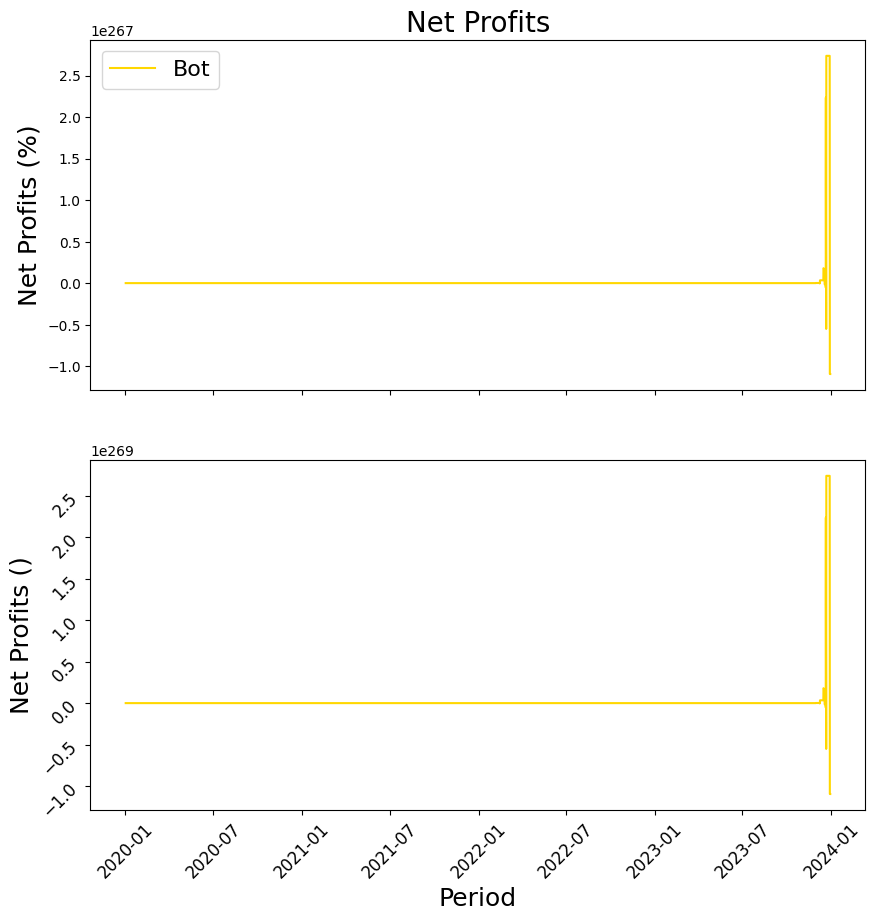

In [46]:

## Profits
show_unrealised = True
show_realised = False
show_hodl = False

profits_bot_realised = ((data['realised_pnl'] - initial_capital)/initial_capital) * 100
profits_bot_unrealised = ((data['unrealised_pnl'] - initial_capital)/initial_capital) * 100
profits_hodl = ((data['hodl'] - data.iloc[0]['hodl'])/data.iloc[0]['hodl']) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
if show_unrealised:
    ax1.plot(data['timestamp'], profits_bot_unrealised, color='gold', label='Bot')
if show_realised:
    ax1.plot(data['timestamp'], profits_bot_realised, color='gold', label='Bot (realised)', ls= '--')
if show_hodl:
    ax1.plot(data['timestamp'], profits_hodl, color='purple', label='Hodl')
ax1.set_title('Net Profits', fontsize=20)
ax1.set_ylabel('Net Profits (%)', fontsize=18)
ax1.set_xticklabels([])
ax1.legend(fontsize=16)
if show_unrealised:
    ax2.plot(data['timestamp'], data['unrealised_pnl'], color='gold', label='Bot')
if show_realised:
    ax2.plot(data['timestamp'], data['realised_pnl'], color='gold', label='Bot (realised)', ls= '--')
if show_hodl:
    ax2.plot(data['timestamp'], data['hodl'], color='purple', label='Hodl')
ax2.set_xlabel('Period', fontsize=18)
ax2.set_ylabel('Net Profits (' + name_quote + ')', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=12, rotation = 45)

print(f" \n\n      ** Profits ** \n")
print(f" > Period: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]} ")
print(f" > Starting balance: {initial_capital} {name_quote}")
print(f" > Final balance Bot: {round(data.iloc[-1]['unrealised_pnl'],2)} {name_quote}")
print(f" > Final balance Hodl: {round(data.iloc[-1]['hodl'],2)} {name_quote}")
print(f" > Bot net profits: {round(profits_bot_unrealised.iloc[-1],2)}%")
print(f" > Hodl net profits: {round(profits_hodl.iloc[-1],2)}%")
print(f" > Net profits ratio Bot / Hodl: {round(data.iloc[-1]['unrealised_pnl']/data.iloc[-1]['hodl'],2)}")


## Trades
orders = pd.json_normalize(backtest_orders, sep='_')
n_orders = len(orders.index)
if not ignore_longs:
    n_longs = orders['type'].value_counts()['long entry']
else:
    n_longs = 0
if not ignore_shorts:
    n_shorts = orders['type'].value_counts()['short entry']
else:
    n_shorts = 0
n_entry_orders = 0
if not ignore_longs:
    n_entry_orders += orders['type'].value_counts()['long entry']
if not ignore_shorts:
    n_entry_orders += orders['type'].value_counts()['short entry']

n_exit_orders = 0
if 'long exit' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['long exit']
if 'long tp' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['long tp']
if 'long sl' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['long sl']
if 'short exit' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['short exit']
if 'short tp' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['short tp']
if 'short sl' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['short sl']

orders.loc[::2, 'pnl'] = np.nan
orders['Win'] = ''
orders.loc[orders['pnl']>0,'Win'] = 'Yes'
orders.loc[orders['pnl']<=0,'Win'] = 'No'
if 'Yes' in orders['Win'].value_counts():
    n_pos_trades = orders['Win'].value_counts()['Yes']
else:
    n_pos_trades = 0
if 'No' in orders['Win'].value_counts():
    n_neg_trades = orders['Win'].value_counts()['No']
else:
    n_neg_trades = 0

winrate = round(n_pos_trades / (n_pos_trades+n_neg_trades) * 100,2)
orders['pnl%'] = orders['pnl'] / (orders['wallet'] - orders['pnl'])  * 100
avg_trades = round(orders['pnl%'].mean(),2)
avg_pos_trades = round(orders.loc[orders['Win'] == 'Yes']['pnl%'].mean(),2)
avg_neg_trades = round(orders.loc[orders['Win'] == 'No']['pnl%'].mean(),2)
best_trade = orders['pnl%'].max()
when_best_trade = orders['timestamp'][orders.loc[orders['pnl%'] == best_trade].index.tolist()[0]]
best_trade = round(best_trade,2)
worst_trade = orders['pnl%'].min()
when_worst_trade = orders['timestamp'][orders.loc[orders['pnl%'] == worst_trade].index.tolist()[0]]
worst_trade = round(worst_trade,2)

print(f" \n\n      ** Trades ** \n")
print(f" > Orders: {n_orders} ({n_entry_orders} buys, {n_exit_orders} sells)")
print(f" > Number of closed trades: {n_pos_trades+n_neg_trades}")
print(f" > Winrate: {winrate}%")
print(f" > Average trade profits: {avg_trades}%")
print(f" > Number of winning trades: {n_pos_trades}")
print(f" > Number of losing trades: {n_neg_trades}")
print(f" > Average winning trades: {avg_pos_trades}%")
print(f" > Average losing trades: {avg_neg_trades}%")
print(f" > Best trade: {best_trade}% on the {when_best_trade}")
print(f" > Worst trade: {worst_trade}% on the {when_worst_trade}")


## Health
worst_drawdown = round(data['drawdown'].min()*100,2)
profit_factor = round(abs(orders.loc[orders['pnl'] > 0, 'pnl'].sum() / orders.loc[orders['pnl'] < 0, 'pnl'].sum()),2)
return_over_max_drawdown = round(profits_bot_unrealised.iloc[-1] / abs(worst_drawdown),2)

print(f" \n\n      ** Health ** \n")
print(f" > Maximum drawdown: {worst_drawdown}%")
print(f" > Profit factor: {profit_factor}")
print(f" > Return over maximum drawdown: {return_over_max_drawdown}")


## fees
total_fee = round(orders['fee'].sum(),2)
biggest_fee = round(orders['fee'].max(),2)
avg_fee = round(orders['fee'].mean(),2)

print(f" \n\n      ** Fees ** \n")
print(f" > Total: {total_fee} {name_quote}")
print(f" > Biggest: {biggest_fee} {name_quote}")
print(f" > Average: {avg_fee} {name_quote} \n")

In [47]:
import pandas as pd

# If you already have 'orders' as a DataFrame, skip this step.
# Otherwise, reconstruct it from your backtest results as shown below:
# orders = pd.json_normalize(backtest_orders, sep='_')

# Extract entry and exit points
entry_types = ['long entry', 'short entry']
exit_types = ['long exit', 'long tp', 'long sl', 'short exit', 'short tp', 'short sl']

entries = orders[orders['type'].isin(entry_types)].copy()
exits = orders[orders['type'].isin(exit_types)].copy()

# For plotting, get the timestamp and price for each entry/exit
entries['timestamp'] = pd.to_datetime(entries['timestamp'])
exits['timestamp'] = pd.to_datetime(exits['timestamp'])

long_entries = entries[entries['type'] == 'long entry']
short_entries = entries[entries['type'] == 'short entry']

long_exits = exits[exits['type'].str.startswith('long')]
short_exits = exits[exits['type'].str.startswith('short')]

In [50]:
print(orders.columns)

Index(['timestamp', 'type', 'amount', 'fee', 'pnl', 'wallet', 'Win', 'pnl%'], dtype='object')


KeyError: 'price'

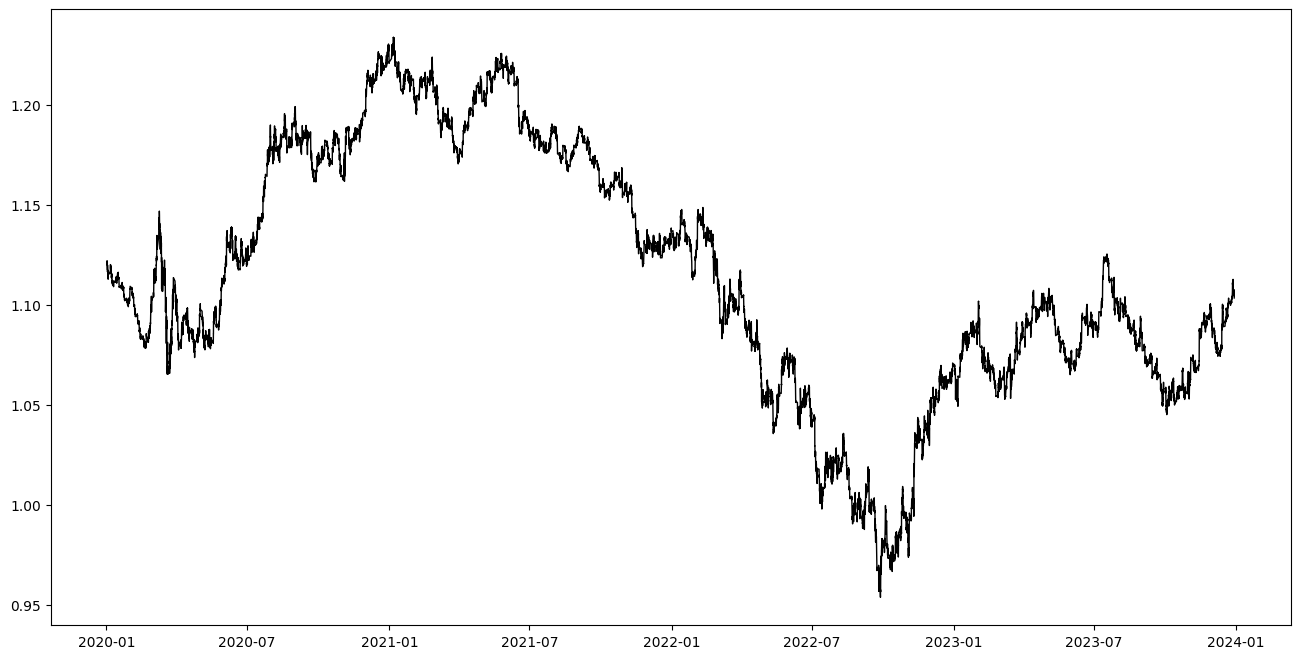

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(data['timestamp'], data['close'], label='Close Price', color='black', linewidth=1)

# Plot long entries (buys)
plt.scatter(long_entries['timestamp'], long_entries['price'], marker='^', color='green', label='Long Entry', s=80, zorder=3)

# Plot short entries (sells)
plt.scatter(short_entries['timestamp'], short_entries['price'], marker='v', color='red', label='Short Entry', s=80, zorder=3)

# Plot exits (all types)
plt.scatter(exits['timestamp'], exits['price'], marker='o', color='blue', label='Exit', s=60, zorder=2, alpha=0.7)

plt.title('Trade Entries and Exits on Price Chart', fontsize=18)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()